# Credit Scoring Model - Re-Optimization

## Improved Hyperparameter Optimization

This notebook re-optimizes the model with better constraints to improve discrimination power on OOT data.

**Key Changes from Original Optimization:**
1. **C constraint**: C >= 0.1 (prevent over-regularization)
2. **Validation-based objective**: Use held-out validation set, not just CV
3. **Monitor overfitting**: Track train-validation gap
4. **Focus on discrimination**: Gini coefficient as primary metric

**Dataset:**
- Training: Second version data (used for optimization)
- Validation: OOT data (third version, 2022-2024) for final evaluation

## 1. Setup & Load Pipeline

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Configuration
# Training data (second version) - CORRECT PATHS
TRAIN_DATA_PATH = 'data/second_version/train_datamart_ish.csv'
TEST_DATA_PATH = 'data/second_version/test_datamart_ish.csv'

# OOT data (third version) 
OOT_TRAIN_PATH = 'data/third_version/TRAIN_DATAMART_2022_2024.csv'
OOT_TEST_PATH = 'data/third_version/TEST_DATAMART_2022_2024.csv'

# Model artifacts
BASELINE_MODEL_PATH = 'outputs/credit_scoring_model.pkl'
OUTPUT_DIR = 'outputs'

TARGET_COL = 'TARGET'
ID_COL = 'MUQAVILE'
RANDOM_STATE = 42
N_FOLDS = 5

print("Configuration loaded successfully")
print(f"Random state: {RANDOM_STATE}")
print(f"CV Folds: {N_FOLDS}")

Configuration loaded successfully
Random state: 42
CV Folds: 5


In [2]:
# Define Pipeline Classes (required for unpickling model artifacts)

class DataPreprocessor:
    """Stage 1: Data cleaning and preprocessing"""
    def __init__(self, target_col, id_col, null_threshold=0.95):
        self.target_col = target_col
        self.id_col = id_col
        self.null_threshold = null_threshold
        self.cols_to_drop = []
        self.categorical_cols = []
        self.numeric_cols = []

    def fit(self, df):
        self.cols_to_drop = [self.id_col] if self.id_col in df.columns else []
        null_rates = df.isnull().mean()
        high_null_cols = null_rates[null_rates > self.null_threshold].index.tolist()
        self.cols_to_drop.extend(high_null_cols)
        remaining_cols = [c for c in df.columns if c not in self.cols_to_drop and c != self.target_col]
        self.categorical_cols = df[remaining_cols].select_dtypes(include=['object']).columns.tolist()
        self.numeric_cols = df[remaining_cols].select_dtypes(include=['number']).columns.tolist()
        return self

    def transform(self, df):
        return df.drop(columns=[c for c in self.cols_to_drop if c in df.columns], errors='ignore')

    def fit_transform(self, df):
        return self.fit(df).transform(df)


class WOEBinner:
    """Stage 2: Weight of Evidence transformation"""
    def __init__(self, max_bins=10, min_samples_bin=0.05, random_state=42):
        self.max_bins = max_bins
        self.min_samples_bin = min_samples_bin
        self.random_state = random_state
        self.binning_tables = {}
        self.iv_values = {}

    def _bin_numeric(self, series, target_series):
        is_null = series.isnull()
        non_null_series = series[~is_null]
        if len(non_null_series) == 0:
            return pd.Series(['MISSING'] * len(series), index=series.index), {'MISSING': (-np.inf, np.inf)}
        n_unique = non_null_series.nunique()
        n_bins = min(self.max_bins, n_unique)
        if n_bins <= 1:
            binned = pd.Series(['BIN_1'] * len(series), index=series.index)
            binned[is_null] = 'MISSING'
            return binned, {'BIN_1': (non_null_series.min(), non_null_series.max()), 'MISSING': (np.nan, np.nan)}
        try:
            binned_non_null, bin_edges = pd.qcut(non_null_series, q=n_bins, retbins=True, duplicates='drop')
            categories = binned_non_null.cat.categories
            binned_non_null = binned_non_null.astype(str)
        except ValueError:
            try:
                binned_non_null, bin_edges = pd.cut(non_null_series, bins=min(5, n_unique), retbins=True, duplicates='drop')
                categories = binned_non_null.cat.categories
                binned_non_null = binned_non_null.astype(str)
            except:
                binned = pd.Series(['BIN_1'] * len(series), index=series.index)
                binned[is_null] = 'MISSING'
                return binned, {'BIN_1': (series.min(), series.max()), 'MISSING': (np.nan, np.nan)}
        binned = pd.Series(index=series.index, dtype=str)
        binned[~is_null] = binned_non_null
        binned[is_null] = 'MISSING'
        bins_dict = {str(cat): (bin_edges[i], bin_edges[i+1]) for i, cat in enumerate(categories) if i < len(bin_edges)-1}
        bins_dict['MISSING'] = (np.nan, np.nan)
        return binned, bins_dict

    def _bin_categorical(self, series):
        return series.fillna('MISSING').astype(str)

    def transform(self, X):
        X_woe = pd.DataFrame(index=X.index)
        for col, binning_info in self.binning_tables.items():
            if col not in X.columns:
                continue
            if binning_info['type'] == 'numeric':
                binned, _ = self._bin_numeric(X[col], pd.Series([0]*len(X)))
            else:
                binned = self._bin_categorical(X[col])
            woe_map = binning_info['woe_map']
            default_woe = np.mean(list(woe_map.values()))
            X_woe[f'{col}_woe'] = binned.map(woe_map).fillna(default_woe)
        return X_woe


class FeatureSelector:
    """Stage 3: Unified Feature Selection"""
    def __init__(self, min_iv=0.02, max_iv=0.5, min_gini=0.01, max_corr=0.85, min_target_corr=0.001, random_state=42):
        self.min_iv = min_iv
        self.max_iv = max_iv
        self.min_gini = min_gini
        self.max_corr = max_corr
        self.min_target_corr = min_target_corr
        self.random_state = random_state
        self.selected_features = []
        self.feature_stats = None
        self.elimination_log = {}

    def transform(self, X_woe):
        available = [f for f in self.selected_features if f in X_woe.columns]
        return X_woe[available].copy()

print("Pipeline classes defined successfully")

Pipeline classes defined successfully


## 2. Load Baseline Model & Pipeline

In [3]:
# Load baseline model and pipeline components
print("Loading baseline model and pipeline...")
with open(BASELINE_MODEL_PATH, 'rb') as f:
    baseline_artifacts = pickle.load(f)

baseline_model = baseline_artifacts['model']
preprocessor = baseline_artifacts['preprocessor']
woe_binner = baseline_artifacts['woe_binner']
feature_selector = baseline_artifacts['feature_selector']

print(f"  - Baseline model type: {type(baseline_model).__name__}")
print(f"  - Selected features: {len(feature_selector.selected_features)}")
print(f"  - Baseline params: C={baseline_model.C}, penalty={baseline_model.penalty}")

print("\nPipeline loaded successfully!")

Loading baseline model and pipeline...


  - Baseline model type: LogisticRegression
  - Selected features: 238
  - Baseline params: C=1.0, penalty=deprecated

Pipeline loaded successfully!


## 3. Load Training Data (Second Version)

In [4]:
# Load training data (second version)
print("Loading training data (second version)...")

train_df = pd.read_csv(TRAIN_DATA_PATH, sep=';', encoding='utf-8-sig')
test_df = pd.read_csv(TEST_DATA_PATH, sep=';', encoding='utf-8-sig')

# Combine for full training set
full_train_df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\n=== Training Data Summary ===")
print(f"Train file: {train_df.shape[0]:,} samples")
print(f"Test file: {test_df.shape[0]:,} samples")
print(f"Combined: {full_train_df.shape[0]:,} samples")
print(f"Features: {full_train_df.shape[1]:,}")

# Target distribution
print(f"\n=== Target Distribution ===")
print(full_train_df[TARGET_COL].value_counts())
print(f"\nTarget rate: {full_train_df[TARGET_COL].mean()*100:.2f}%")

Loading training data (second version)...



=== Training Data Summary ===
Train file: 85,955 samples
Test file: 10,734 samples
Combined: 96,689 samples
Features: 2,739

=== Target Distribution ===
TARGET
0    94924
1     1765
Name: count, dtype: int64

Target rate: 1.83%


## 4. Process Data Through Pipeline

In [5]:
def process_data(df, preprocessor, woe_binner, feature_selector):
    """Process data through the trained pipeline."""
    # Step 1: Preprocess
    df_clean = preprocessor.transform(df)
    
    # Step 2: Extract features and target
    X = df_clean.drop(columns=[TARGET_COL], errors='ignore')
    y = df_clean[TARGET_COL] if TARGET_COL in df_clean.columns else None
    
    # Step 3: WOE transformation
    X_woe = woe_binner.transform(X)
    
    # Step 4: Feature selection
    X_selected = feature_selector.transform(X_woe)
    
    # Step 5: Handle missing values
    X_final = X_selected.fillna(0)
    
    # Step 6: Ensure all features present
    missing_features = set(feature_selector.selected_features) - set(X_final.columns)
    if missing_features:
        print(f"  Note: {len(missing_features)} feature(s) missing, filling with 0")
        for feat in missing_features:
            X_final[feat] = 0
        X_final = X_final[feature_selector.selected_features]
    
    return X_final, y

# Process training data (second version)
print("Processing training data...")
X_full, y_full = process_data(full_train_df, preprocessor, woe_binner, feature_selector)
print(f"  Full dataset shape: {X_full.shape}")

# Split into train/validation/test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.4, random_state=RANDOM_STATE, stratify=y_full
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"\n=== Data Splits (Second Version) ===")
print(f"Train: {X_train.shape[0]:,} samples ({y_train.mean()*100:.2f}% default)")
print(f"Validation: {X_val.shape[0]:,} samples ({y_val.mean()*100:.2f}% default)")
print(f"Test: {X_test.shape[0]:,} samples ({y_test.mean()*100:.2f}% default)")
print(f"\nFeatures: {X_train.shape[1]}")

Processing training data...


  Full dataset shape: (96689, 238)



=== Data Splits (Second Version) ===
Train: 58,013 samples (1.83% default)
Validation: 19,338 samples (1.83% default)
Test: 19,338 samples (1.83% default)

Features: 238


## 5. Improved Model Optimizer

In [6]:
def gini_score(y_true, y_pred):
    """Calculate Gini coefficient"""
    return 2 * roc_auc_score(y_true, y_pred) - 1

class ImprovedModelOptimizer:
    """
    Bayesian Hyperparameter Optimization with Improved Constraints
    
    Key improvements:
    1. C >= 0.1 (prevent over-regularization)
    2. Track CV Gini, Validation Gini, and Test Gini
    3. Monitor train-validation gap for overfitting
    4. Focus on discrimination (Gini) as primary metric
    """
    
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, 
                 n_folds=5, random_state=42):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.n_folds = n_folds
        self.random_state = random_state
        self.study = None
        self.best_params = None
        self.results_log = []
    
    def objective(self, trial):
        """Optuna objective - maximize validation Gini while monitoring CV"""
        
        # Hyperparameter search space with BETTER CONSTRAINTS
        # C >= 0.1 to prevent over-regularization
        C = trial.suggest_float('C', 0.1, 10.0, log=True)
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
        
        params = {
            'C': C,
            'penalty': penalty,
            'solver': 'saga',
            'max_iter': 1000,
            'random_state': self.random_state,
            'class_weight': 'balanced'
        }
        
        if penalty == 'elasticnet':
            params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.1, 0.9)
        
        # 1. Cross-validation on training data
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, 
                              random_state=self.random_state)
        cv_gini_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(self.X_train, self.y_train)):
            model = LogisticRegression(**params)
            model.fit(self.X_train.iloc[train_idx], self.y_train.iloc[train_idx])
            y_pred = model.predict_proba(self.X_train.iloc[val_idx])[:, 1]
            fold_gini = gini_score(self.y_train.iloc[val_idx], y_pred)
            cv_gini_scores.append(fold_gini)
            
            # Early pruning based on CV performance
            trial.report(np.mean(cv_gini_scores), fold)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        cv_gini = np.mean(cv_gini_scores)
        
        # 2. Train on full training set and evaluate on validation
        model = LogisticRegression(**params)
        model.fit(self.X_train, self.y_train)
        
        # Validation Gini
        y_val_pred = model.predict_proba(self.X_val)[:, 1]
        val_gini = gini_score(self.y_val, y_val_pred)
        
        # Test Gini (for monitoring only)
        y_test_pred = model.predict_proba(self.X_test)[:, 1]
        test_gini = gini_score(self.y_test, y_test_pred)
        
        # Log results
        self.results_log.append({
            'trial': trial.number,
            'C': C,
            'penalty': penalty,
            'l1_ratio': params.get('l1_ratio', None),
            'cv_gini': cv_gini,
            'val_gini': val_gini,
            'test_gini': test_gini,
            'cv_val_gap': cv_gini - val_gini
        })
        
        # Store metrics in trial for later analysis
        trial.set_user_attr('cv_gini', cv_gini)
        trial.set_user_attr('val_gini', val_gini)
        trial.set_user_attr('test_gini', test_gini)
        
        # OBJECTIVE: Maximize validation Gini (discrimination on held-out data)
        return val_gini
    
    def optimize(self, n_trials=50):
        """Run Bayesian optimization"""
        self.study = optuna.create_study(
            direction='maximize',
            pruner=MedianPruner(n_warmup_steps=3)
        )
        
        self.study.optimize(
            self.objective, 
            n_trials=n_trials,
            show_progress_bar=True
        )
        
        self.best_params = self.study.best_params
        return self.best_params
    
    def get_results_df(self):
        """Get results as DataFrame"""
        return pd.DataFrame(self.results_log)
    
    def print_best_results(self):
        """Print best trial results"""
        best_trial = self.study.best_trial
        print(f"\n{'='*60}")
        print("BEST TRIAL RESULTS")
        print(f"{'='*60}")
        print(f"Trial number: {best_trial.number}")
        print(f"\nHyperparameters:")
        for key, value in best_trial.params.items():
            print(f"  {key}: {value}")
        print(f"\nMetrics:")
        print(f"  CV Gini:         {best_trial.user_attrs['cv_gini']:.4f}")
        print(f"  Validation Gini: {best_trial.user_attrs['val_gini']:.4f}")
        print(f"  Test Gini:       {best_trial.user_attrs['test_gini']:.4f}")
        print(f"  CV-Val Gap:      {best_trial.user_attrs['cv_gini'] - best_trial.user_attrs['val_gini']:.4f}")

print("ImprovedModelOptimizer class defined")
print("\nKey improvements:")
print("  - C constrained to [0.1, 10.0] (no over-regularization)")
print("  - Objective: Maximize VALIDATION Gini (not CV Gini)")
print("  - Tracks: CV Gini, Validation Gini, Test Gini")
print("  - Monitors: CV-Validation gap for overfitting")

ImprovedModelOptimizer class defined

Key improvements:
  - C constrained to [0.1, 10.0] (no over-regularization)
  - Objective: Maximize VALIDATION Gini (not CV Gini)
  - Tracks: CV Gini, Validation Gini, Test Gini
  - Monitors: CV-Validation gap for overfitting


## 6. Run Optimization

In [7]:
# Run improved optimization
print("="*60)
print("STARTING IMPROVED HYPERPARAMETER OPTIMIZATION")
print("="*60)
print(f"\nTrials: 50")
print(f"CV Folds: {N_FOLDS}")
print(f"C range: [0.1, 10.0] (constrained)")
print(f"Objective: Maximize VALIDATION Gini")
print()

optimizer = ImprovedModelOptimizer(
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    n_folds=N_FOLDS,
    random_state=RANDOM_STATE
)

best_params = optimizer.optimize(n_trials=50)
optimizer.print_best_results()

STARTING IMPROVED HYPERPARAMETER OPTIMIZATION

Trials: 50
CV Folds: 5
C range: [0.1, 10.0] (constrained)
Objective: Maximize VALIDATION Gini



  0%|          | 0/50 [00:00<?, ?it/s]


BEST TRIAL RESULTS
Trial number: 22

Hyperparameters:
  C: 2.387238810211886
  penalty: elasticnet
  l1_ratio: 0.6750974586809928

Metrics:
  CV Gini:         0.4208
  Validation Gini: 0.4626
  Test Gini:       0.4971
  CV-Val Gap:      -0.0418


## 7. Train Final Model with Best Parameters

In [8]:
# Build final model with best parameters
best_trial = optimizer.study.best_trial

opt_params = {
    'C': best_params['C'],
    'penalty': best_params['penalty'],
    'solver': 'saga',
    'max_iter': 1000,
    'random_state': RANDOM_STATE,
    'class_weight': 'balanced'
}

if best_params['penalty'] == 'elasticnet':
    opt_params['l1_ratio'] = best_params['l1_ratio']

# Train on full training data (train + validation)
X_train_full = pd.concat([X_train, X_val], ignore_index=True)
y_train_full = pd.concat([y_train, y_val], ignore_index=True)

print("Training final model on full training data...")
reopt_model = LogisticRegression(**opt_params)
reopt_model.fit(X_train_full, y_train_full)

# Evaluate on test set
y_test_pred_reopt = reopt_model.predict_proba(X_test)[:, 1]
test_gini_reopt = gini_score(y_test, y_test_pred_reopt)
test_auc_reopt = roc_auc_score(y_test, y_test_pred_reopt)

# Compare with baseline
y_test_pred_baseline = baseline_model.predict_proba(X_test)[:, 1]
test_gini_baseline = gini_score(y_test, y_test_pred_baseline)
test_auc_baseline = roc_auc_score(y_test, y_test_pred_baseline)

print(f"\n{'='*60}")
print("FINAL MODEL COMPARISON (Test Set - Second Version)")
print(f"{'='*60}")
print(f"\n{'Metric':<20} {'Baseline':<15} {'Re-Optimized':<15} {'Change':<15}")
print("-"*60)
print(f"{'Test AUC':<20} {test_auc_baseline:<15.4f} {test_auc_reopt:<15.4f} {test_auc_reopt - test_auc_baseline:+.4f}")
print(f"{'Test Gini':<20} {test_gini_baseline:<15.4f} {test_gini_reopt:<15.4f} {test_gini_reopt - test_gini_baseline:+.4f}")
print(f"{'C value':<20} {baseline_model.C:<15.4f} {opt_params['C']:<15.4f}")
print(f"{'Penalty':<20} {baseline_model.penalty:<15} {opt_params['penalty']:<15}")

Training final model on full training data...



FINAL MODEL COMPARISON (Test Set - Second Version)

Metric               Baseline        Re-Optimized    Change         
------------------------------------------------------------
Test AUC             0.7662          0.6870          -0.0792
Test Gini            0.5324          0.3740          -0.1584
C value              1.0000          2.3872         
Penalty              deprecated      elasticnet     


## 8. Load OOT Data (Third Version) for Final Validation

In [9]:
# Load OOT data (third version)
print("Loading OOT data (third version 2022-2024)...")

# Column mapping for third version
COLUMN_MAPPING = {
    'IbsWorkPositionType': 'WORKGROUP',
    'IbsWorkSegment': 'SAHƏLƏR',
    'LopWorkGroup': 'PARTNYORLUQ'
}

oot_train = pd.read_csv(OOT_TRAIN_PATH, sep=';', encoding='utf-8-sig')
oot_test = pd.read_csv(OOT_TEST_PATH, sep=';', encoding='utf-8-sig')
oot_df = pd.concat([oot_train, oot_test], ignore_index=True)

# Apply column mapping
for old_name, new_name in COLUMN_MAPPING.items():
    if old_name in oot_df.columns:
        oot_df = oot_df.rename(columns={old_name: new_name})

print(f"OOT samples: {len(oot_df):,}")
print(f"OOT target rate: {oot_df[TARGET_COL].mean()*100:.2f}%")

# Process OOT data
print("\nProcessing OOT data...")
X_oot, y_oot = process_data(oot_df, preprocessor, woe_binner, feature_selector)
print(f"OOT shape: {X_oot.shape}")

# Generate OOT predictions
print("\nGenerating OOT predictions...")
y_oot_pred_baseline = baseline_model.predict_proba(X_oot)[:, 1]
y_oot_pred_reopt = reopt_model.predict_proba(X_oot)[:, 1]

# Calculate OOT metrics
oot_gini_baseline = gini_score(y_oot, y_oot_pred_baseline)
oot_gini_reopt = gini_score(y_oot, y_oot_pred_reopt)
oot_auc_baseline = roc_auc_score(y_oot, y_oot_pred_baseline)
oot_auc_reopt = roc_auc_score(y_oot, y_oot_pred_reopt)
oot_brier_baseline = brier_score_loss(y_oot, y_oot_pred_baseline)
oot_brier_reopt = brier_score_loss(y_oot, y_oot_pred_reopt)

print(f"\n{'='*60}")
print("OOT VALIDATION RESULTS (Third Version 2022-2024)")
print(f"{'='*60}")
print(f"\n{'Metric':<20} {'Baseline':<15} {'Re-Optimized':<15} {'Change':<15}")
print("-"*60)
print(f"{'OOT AUC':<20} {oot_auc_baseline:<15.4f} {oot_auc_reopt:<15.4f} {oot_auc_reopt - oot_auc_baseline:+.4f}")
print(f"{'OOT Gini':<20} {oot_gini_baseline:<15.4f} {oot_gini_reopt:<15.4f} {oot_gini_reopt - oot_gini_baseline:+.4f}")
print(f"{'OOT Brier':<20} {oot_brier_baseline:<15.4f} {oot_brier_reopt:<15.4f} {oot_brier_reopt - oot_brier_baseline:+.4f}")

Loading OOT data (third version 2022-2024)...


OOT samples: 96,757
OOT target rate: 0.87%

Processing OOT data...


  Note: 1 feature(s) missing, filling with 0


OOT shape: (96757, 238)

Generating OOT predictions...



OOT VALIDATION RESULTS (Third Version 2022-2024)

Metric               Baseline        Re-Optimized    Change         
------------------------------------------------------------
OOT AUC              0.6204          0.6735          +0.0531
OOT Gini             0.2409          0.3470          +0.1061
OOT Brier            0.0715          0.2304          +0.1589


## 9. Visualizations

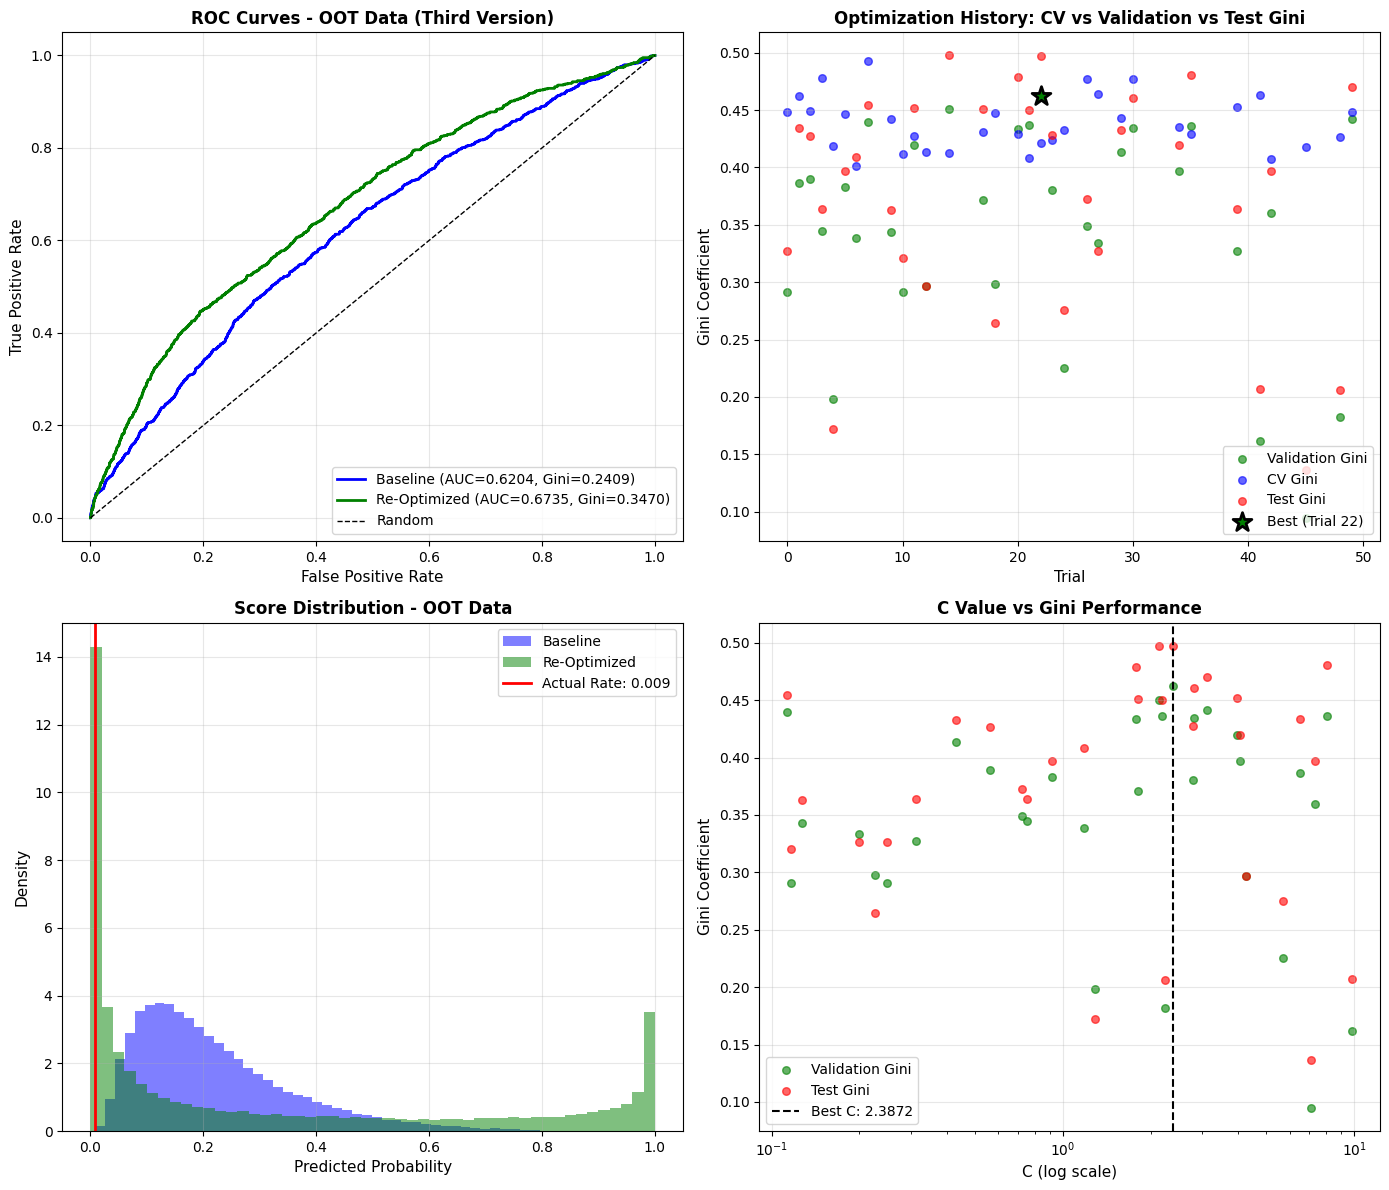


Visualization saved to 'outputs/reoptimization_results.png'


In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curves - OOT Data
ax = axes[0, 0]
for name, preds, color in [('Baseline', y_oot_pred_baseline, 'blue'), 
                            ('Re-Optimized', y_oot_pred_reopt, 'green')]:
    fpr, tpr, _ = roc_curve(y_oot, preds)
    auc = roc_auc_score(y_oot, preds)
    gini = 2 * auc - 1
    ax.plot(fpr, tpr, color=color, linewidth=2, 
            label=f'{name} (AUC={auc:.4f}, Gini={gini:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves - OOT Data (Third Version)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 2. Optimization History
ax = axes[0, 1]
results_df = optimizer.get_results_df()
ax.scatter(results_df['trial'], results_df['val_gini'], 
           c='green', alpha=0.6, s=30, label='Validation Gini')
ax.scatter(results_df['trial'], results_df['cv_gini'], 
           c='blue', alpha=0.6, s=30, label='CV Gini')
ax.scatter(results_df['trial'], results_df['test_gini'], 
           c='red', alpha=0.6, s=30, label='Test Gini')

# Mark best trial
best_idx = results_df['val_gini'].idxmax()
ax.scatter(results_df.loc[best_idx, 'trial'], results_df.loc[best_idx, 'val_gini'],
           c='green', s=200, marker='*', edgecolors='black', linewidths=2, 
           label=f'Best (Trial {int(results_df.loc[best_idx, "trial"])})', zorder=5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Gini Coefficient', fontsize=11)
ax.set_title('Optimization History: CV vs Validation vs Test Gini', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 3. Score Distribution Comparison - OOT
ax = axes[1, 0]
ax.hist(y_oot_pred_baseline, bins=50, alpha=0.5, label='Baseline', density=True, color='blue')
ax.hist(y_oot_pred_reopt, bins=50, alpha=0.5, label='Re-Optimized', density=True, color='green')
ax.axvline(y_oot.mean(), color='red', linestyle='-', linewidth=2, label=f'Actual Rate: {y_oot.mean():.3f}')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Score Distribution - OOT Data', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. C Value vs Gini
ax = axes[1, 1]
ax.scatter(results_df['C'], results_df['val_gini'], c='green', alpha=0.6, s=30, label='Validation Gini')
ax.scatter(results_df['C'], results_df['test_gini'], c='red', alpha=0.6, s=30, label='Test Gini')
ax.set_xscale('log')
ax.axvline(best_params['C'], color='black', linestyle='--', label=f'Best C: {best_params["C"]:.4f}')
ax.set_xlabel('C (log scale)', fontsize=11)
ax.set_ylabel('Gini Coefficient', fontsize=11)
ax.set_title('C Value vs Gini Performance', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/reoptimization_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to '{OUTPUT_DIR}/reoptimization_results.png'")

## 10. Save Results

In [11]:
# Save optimization results
results_df = optimizer.get_results_df()
results_df.to_csv(f'{OUTPUT_DIR}/reoptimization_history.csv', index=False)
print(f"Optimization history saved to '{OUTPUT_DIR}/reoptimization_history.csv'")

# Save model artifacts
reopt_artifacts = {
    'model': reopt_model,
    'preprocessor': preprocessor,
    'woe_binner': woe_binner,
    'feature_selector': feature_selector,
    'best_params': best_params,
    'metrics': {
        'cv_gini': best_trial.user_attrs['cv_gini'],
        'val_gini': best_trial.user_attrs['val_gini'],
        'test_gini': best_trial.user_attrs['test_gini'],
        'oot_gini': oot_gini_reopt,
        'oot_auc': oot_auc_reopt,
        'oot_brier': oot_brier_reopt
    }
}

with open(f'{OUTPUT_DIR}/credit_scoring_model_reoptimized.pkl', 'wb') as f:
    pickle.dump(reopt_artifacts, f)
print(f"Model saved to '{OUTPUT_DIR}/credit_scoring_model_reoptimized.pkl'")

# Save OOT predictions
oot_predictions = pd.DataFrame({
    ID_COL: oot_df[ID_COL].values,
    'prediction_baseline': y_oot_pred_baseline,
    'prediction_reoptimized': y_oot_pred_reopt,
    'actual': y_oot.values
})
oot_predictions.to_csv(f'{OUTPUT_DIR}/oot_predictions_reoptimized.csv', index=False)
print(f"OOT predictions saved to '{OUTPUT_DIR}/oot_predictions_reoptimized.csv'")

# Final Summary
print(f"\n{'='*70}")
print("FINAL SUMMARY - RE-OPTIMIZATION RESULTS")
print(f"{'='*70}")

print(f"\n1. OPTIMIZATION CONFIGURATION:")
print(f"   - C range: [0.1, 10.0] (constrained)")
print(f"   - Objective: Maximize Validation Gini")
print(f"   - Trials: 50")

print(f"\n2. BEST HYPERPARAMETERS:")
print(f"   - C: {best_params['C']:.4f}")
print(f"   - Penalty: {best_params['penalty']}")
if 'l1_ratio' in best_params:
    print(f"   - L1 ratio: {best_params['l1_ratio']:.4f}")

print(f"\n3. PERFORMANCE COMPARISON:")
print(f"   {'Dataset':<25} {'Baseline Gini':<18} {'Re-Opt Gini':<18} {'Change':<12}")
print(f"   {'-'*70}")
print(f"   {'Test (v2)':<25} {test_gini_baseline:<18.4f} {test_gini_reopt:<18.4f} {test_gini_reopt - test_gini_baseline:+.4f}")
print(f"   {'OOT (v3)':<25} {oot_gini_baseline:<18.4f} {oot_gini_reopt:<18.4f} {oot_gini_reopt - oot_gini_baseline:+.4f}")

print(f"\n4. OUTPUT FILES:")
print(f"   - {OUTPUT_DIR}/credit_scoring_model_reoptimized.pkl")
print(f"   - {OUTPUT_DIR}/reoptimization_history.csv")
print(f"   - {OUTPUT_DIR}/oot_predictions_reoptimized.csv")
print(f"   - {OUTPUT_DIR}/reoptimization_results.png")

print(f"\n{'='*70}")
print("Re-optimization completed successfully!")
print(f"{'='*70}")

Optimization history saved to 'outputs/reoptimization_history.csv'


Model saved to 'outputs/credit_scoring_model_reoptimized.pkl'


OOT predictions saved to 'outputs/oot_predictions_reoptimized.csv'

FINAL SUMMARY - RE-OPTIMIZATION RESULTS

1. OPTIMIZATION CONFIGURATION:
   - C range: [0.1, 10.0] (constrained)
   - Objective: Maximize Validation Gini
   - Trials: 50

2. BEST HYPERPARAMETERS:
   - C: 2.3872
   - Penalty: elasticnet
   - L1 ratio: 0.6751

3. PERFORMANCE COMPARISON:
   Dataset                   Baseline Gini      Re-Opt Gini        Change      
   ----------------------------------------------------------------------
   Test (v2)                 0.5324             0.3740             -0.1584
   OOT (v3)                  0.2409             0.3470             +0.1061

4. OUTPUT FILES:
   - outputs/credit_scoring_model_reoptimized.pkl
   - outputs/reoptimization_history.csv
   - outputs/oot_predictions_reoptimized.csv
   - outputs/reoptimization_results.png

Re-optimization completed successfully!
